In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# laod data

In [2]:
import os
import pandas as pd
import numpy as np 


def load_data_time(directory = 'data/group3/config_1', all_data=[], labels=[]):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        all_data.append(np.array(data))
        # formatage des labels pour chaque pas de temps
        if directory == 'data/h_config1-lcb':
            _label = int(filename[2])
        elif directory == 'data/v_config1-lcb':
            _label = int(filename[10])
        elif directory == 'data/groupe1_groupe2':
            _label = int(filename.split('_')[1])
        else :
            _label = int(filename[0])
        labels.append(np.array([_label]*len(data)).reshape(-1,1))
    columns_name = pd.read_csv(os.path.join(directory, os.listdir(directory)[1])).columns.tolist()
    return all_data, labels, columns_name

# load horizontal
all_data, labels, _ = load_data_time()
print(len(all_data))
all_data, labels, _ = load_data_time('data/h_config1-lcb',all_data,labels)
print(len(all_data))
# load vertical
all_data, labels, _ = load_data_time('data/v_config1-lcb',all_data,labels)
print(len(all_data))
# load 3D
all_data, labels, _ = load_data_time('data/groupe1_groupe2',all_data,labels)
print(len(all_data))

223
528
831
1154


# initialize the reservoir coomputing
* https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb

In [3]:
import reservoirpy as rpy

rpy.verbosity(0) 
rpy.set_seed(42) 

In [4]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

## process label 
* we need one hot encoded matrice for classification
* we need a class for each time_step

In [5]:
####################################
### preprocessing y pour RC       ##
####################################


from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit_transform(np.array(np.arange(10).reshape(-1,1)))

new_label=[]
for i in range(len(all_data)):
    new_label.append(enc.transform(labels[i]).toarray())#np.tile(enc.transform(labels[i]), (len(all_data[i]), 1)))
print("On transforme les label en one hot encoded:\n",new_label[0][:10])

On transforme les label en one hot encoded:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [6]:
n_train = len(all_data)//4
idx_test = np.random.choice(np.arange(len(all_data)), n_train)
idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test)))

X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]



esn_model = esn_model.fit(X_train, y_train, warmup=10)

print("reservoir initialize, ")
print(reservoir.is_initialized, ridge.is_initialized, ridge.fitted)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# predictions

In [7]:
Y_pred = esn_model.run(X_test)

In [18]:
preds[0]

[array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),


### on compatibilize

/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_46898/3257551410.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_y_pred = [int(time_serie[-1]) for time_serie in decoded_preds]


In [10]:

preds=[]
for i in range(len(Y_pred)):
    res_ = []
    for timestep in range(len(Y_pred[i])):
        u = np.zeros(10)
        u[np.argmax(Y_pred[i][timestep])] = 1
        res_.append(u)
    preds.append(res_)

decoded_preds = [enc.inverse_transform(label) for label in preds]
label_y_pred = [int(time_serie[-1]) for time_serie in decoded_preds]

decoded_y_test = [enc.inverse_transform(label) for label in y_test]   # take n_timestep as prediction
label_y_test = [int(time_serie[0]) for time_serie in decoded_y_test]  # take the first label of the time serie (its the same along the time serie)

/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_46898/2268077266.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_y_test = [int(time_serie[0]) for time_serie in decoded_y_test]


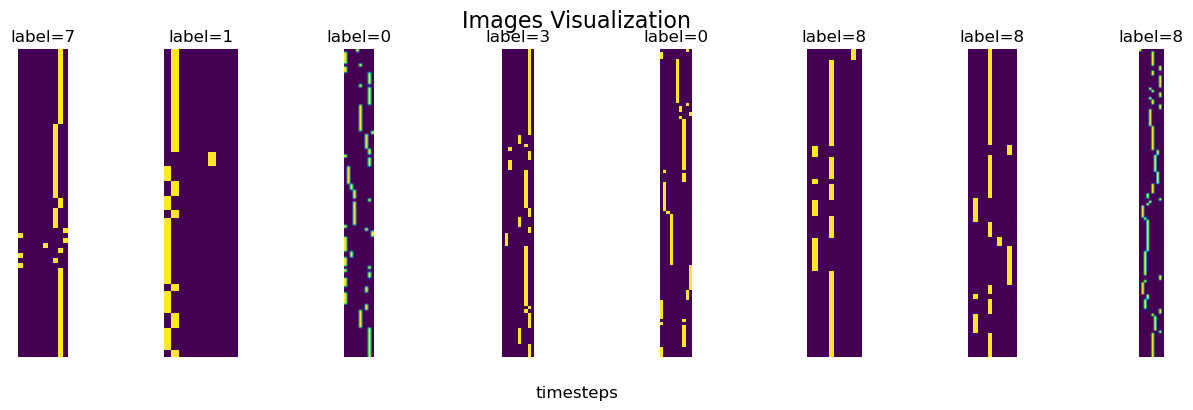

In [13]:


# Create subplots
fig, ax = plt.subplots(1, 8, figsize=(16, 4))  # Adjust figsize according to your needs

# Loop through random indices and display the corresponding images
for i, n in enumerate(np.random.choice(len(y_test), 8, replace=False)):
    ax[i].imshow(preds[n])
    ax[i].axis('off')  # Turn off axis for cleaner display
    ax[i].set_title(f"label={label_y_test[n]}")
fig.suptitle("Images Visualization", fontsize=16)
fig.text(0.5, 0.01, 'timesteps', ha='center', fontsize=12)
plt.show()


In [14]:
res_ = []
labels=[]
for i in range(len(y_test)):
    for timestep in range(len(y_test[i])):
        u = np.zeros(10)
        u[np.argmax(y_test[i][timestep])] = 1
        res_.append(u)
    labels.append(np.argmax(pd.DataFrame(np.array(res_).T).sum(axis=1)))


0.2152777777777778
              precision    recall  f1-score   support

           0       0.50      0.17      0.26        35
           1       0.37      0.40      0.38        25
           2       0.38      0.09      0.15        32
           3       0.20      0.03      0.06        29
           4       0.11      0.26      0.16        23
           5       0.00      0.00      0.00        20
           6       0.33      0.07      0.11        29
           7       0.33      0.15      0.21        26
           8       0.17      0.62      0.27        34
           9       0.30      0.26      0.28        35

    accuracy                           0.22       288
   macro avg       0.27      0.21      0.19       288
weighted avg       0.28      0.22      0.20       288



<Axes: >

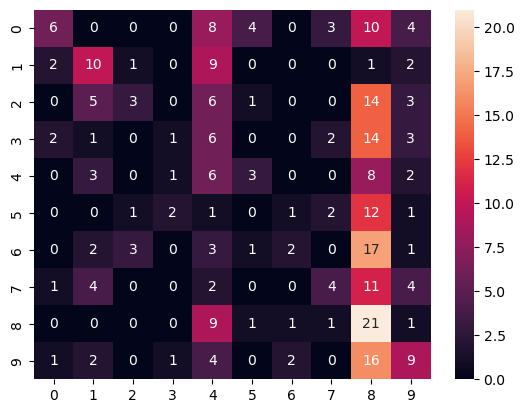

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import classification_report

print(accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)